In [22]:
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.utils import first
from monai.transforms import Activations

In [23]:
in_dir = '/Users/pratyush/Downloads/liversegmentation/data_train_test'
model_dir = '/Users/pratyush/Downloads/liversegmentation/results/results' 

In [24]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

In [25]:
test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol', allow_smaller=True),
            Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
            ToTensord(keys=["vol", "seg"]),
        ]
    )


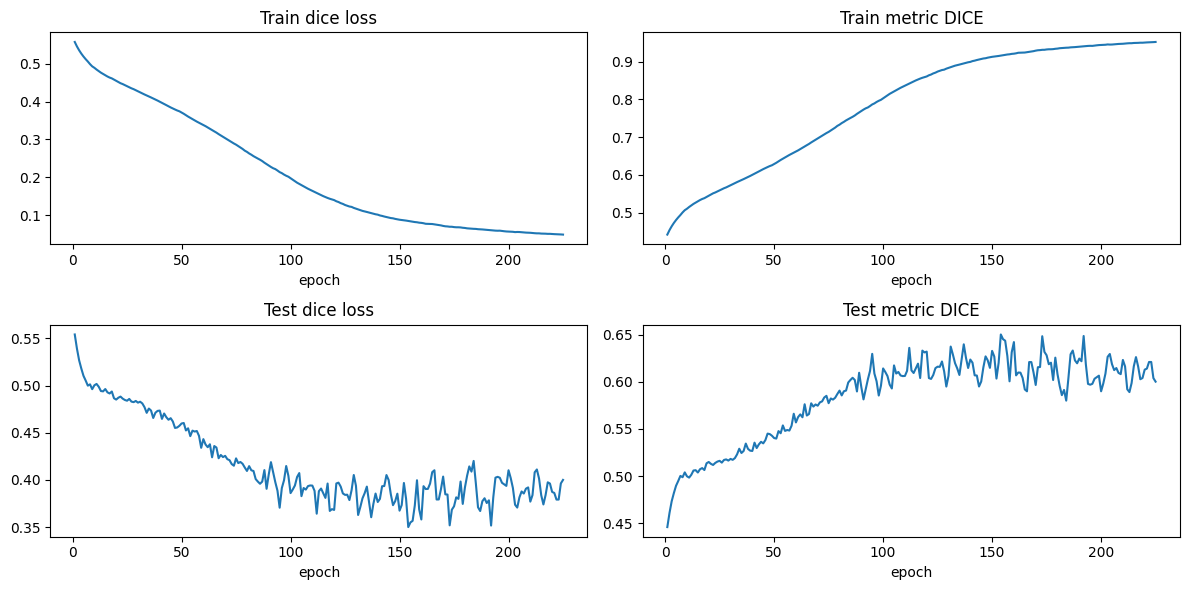

In [26]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)
plt.tight_layout()
plt.show()

In [32]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[2:12]

In [33]:
test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"],a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol", allow_smaller=True),
            Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

In [34]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [35]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [36]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_27869/2870938610.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


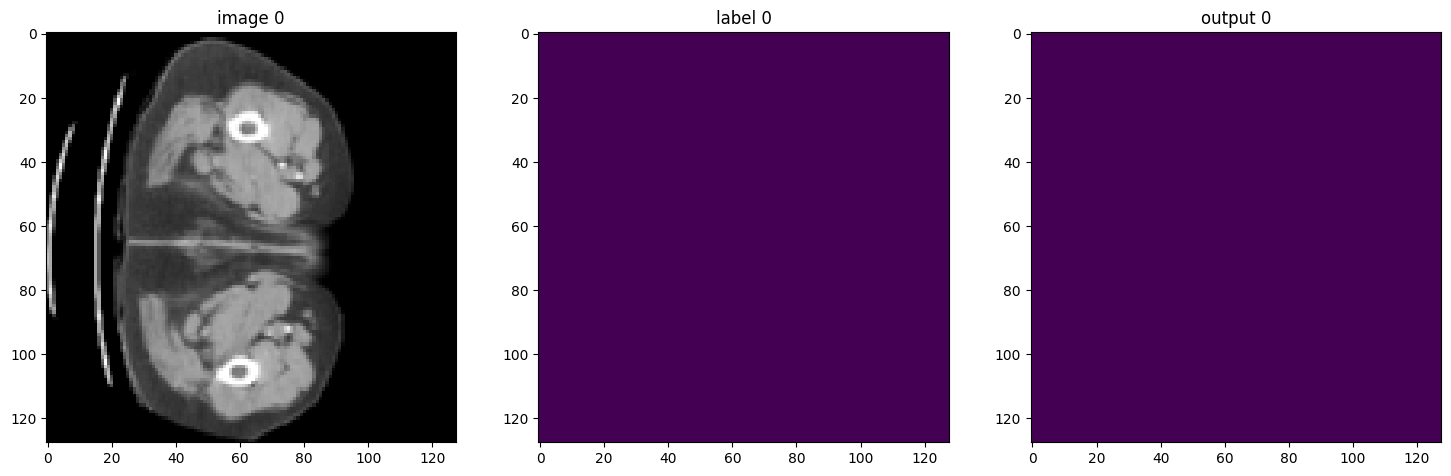

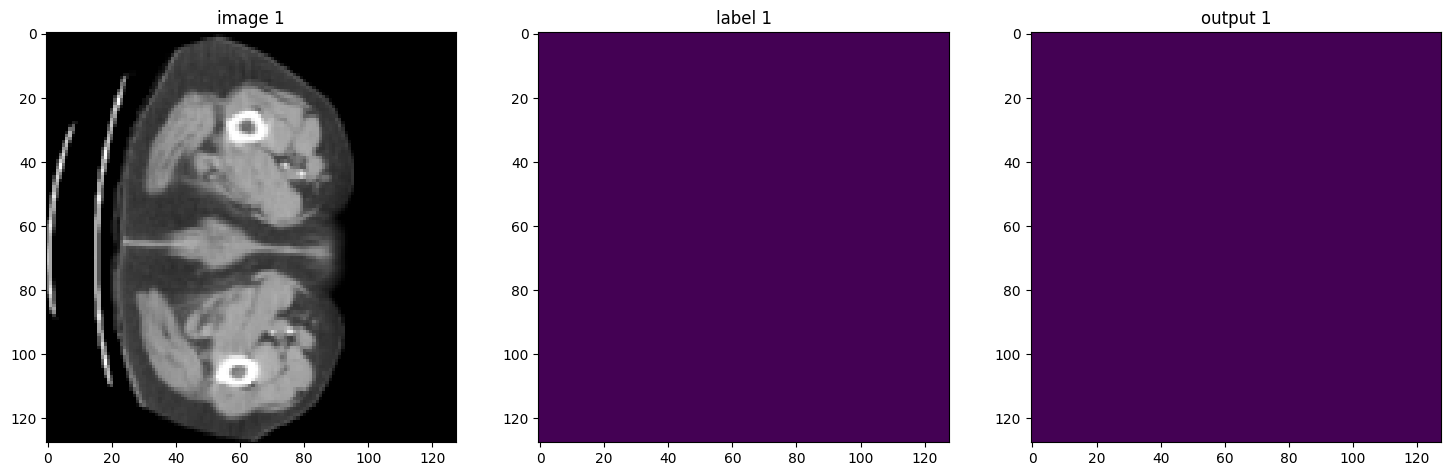

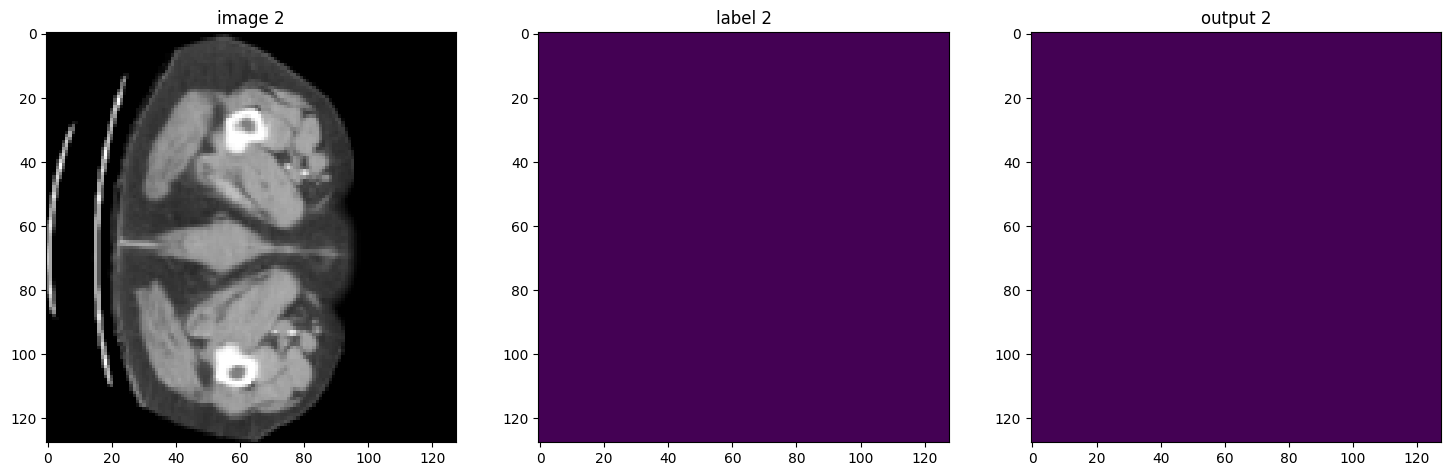

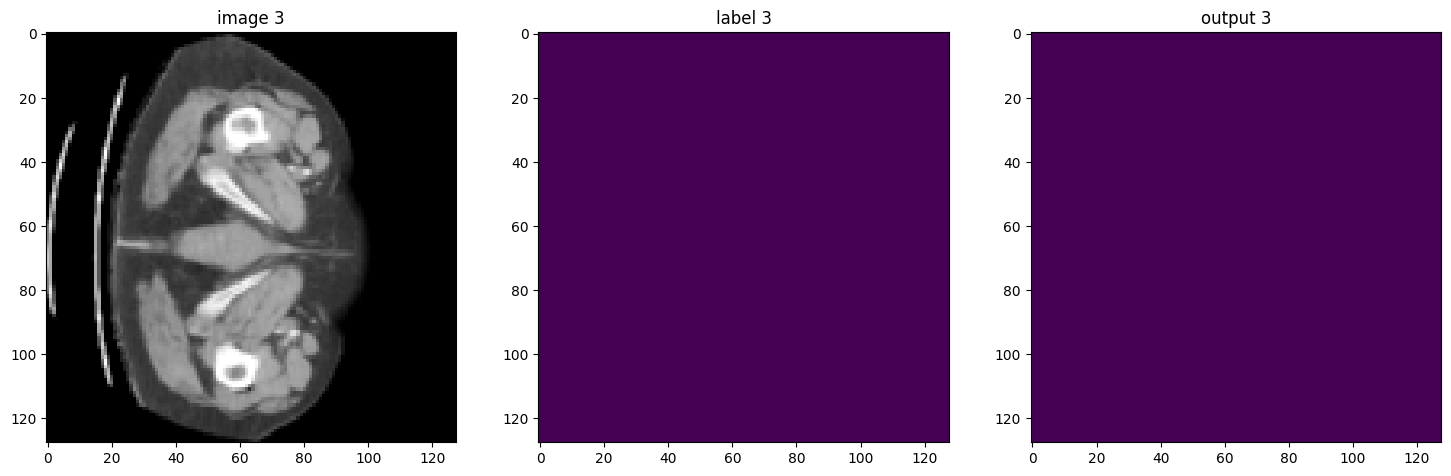

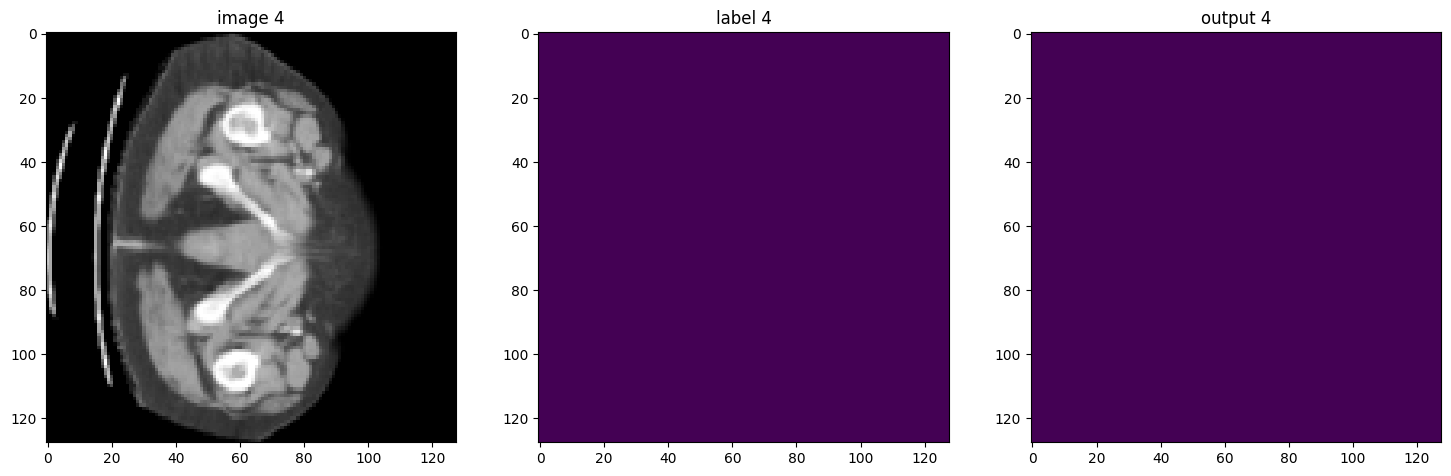

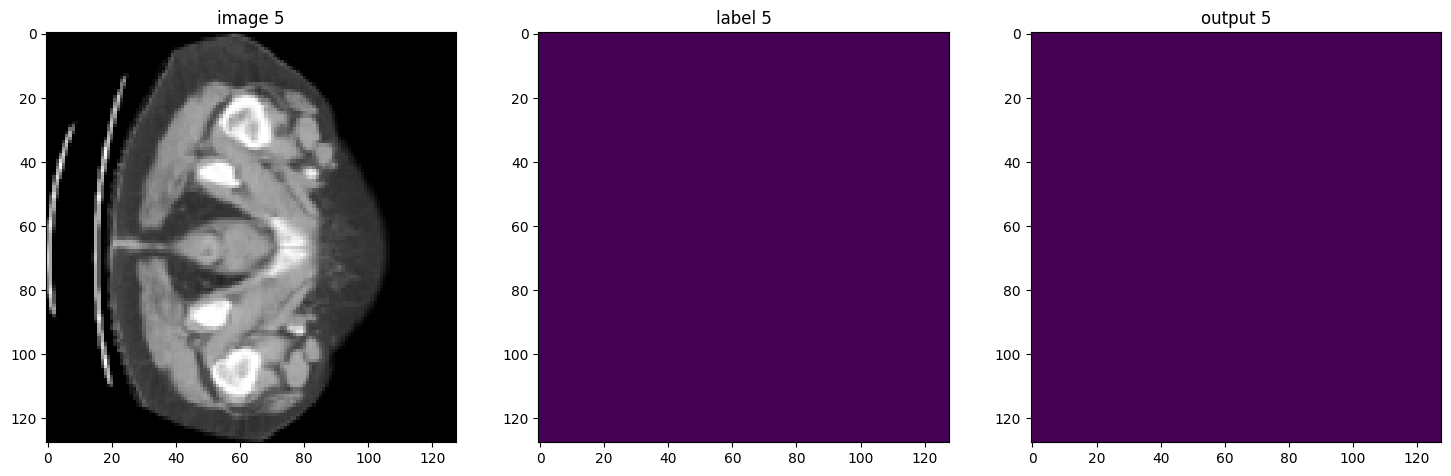

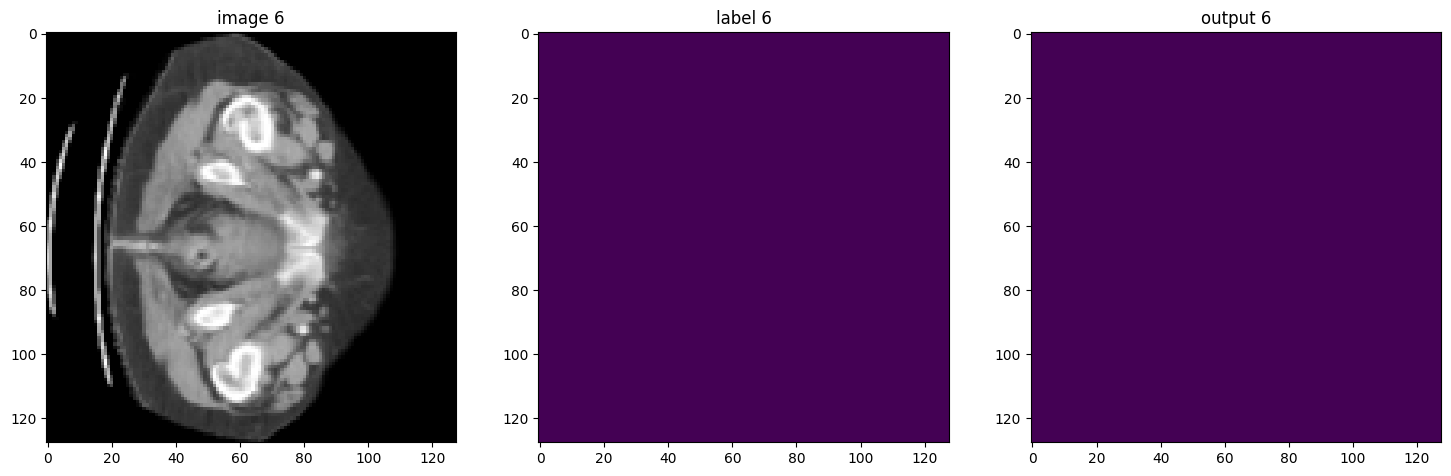

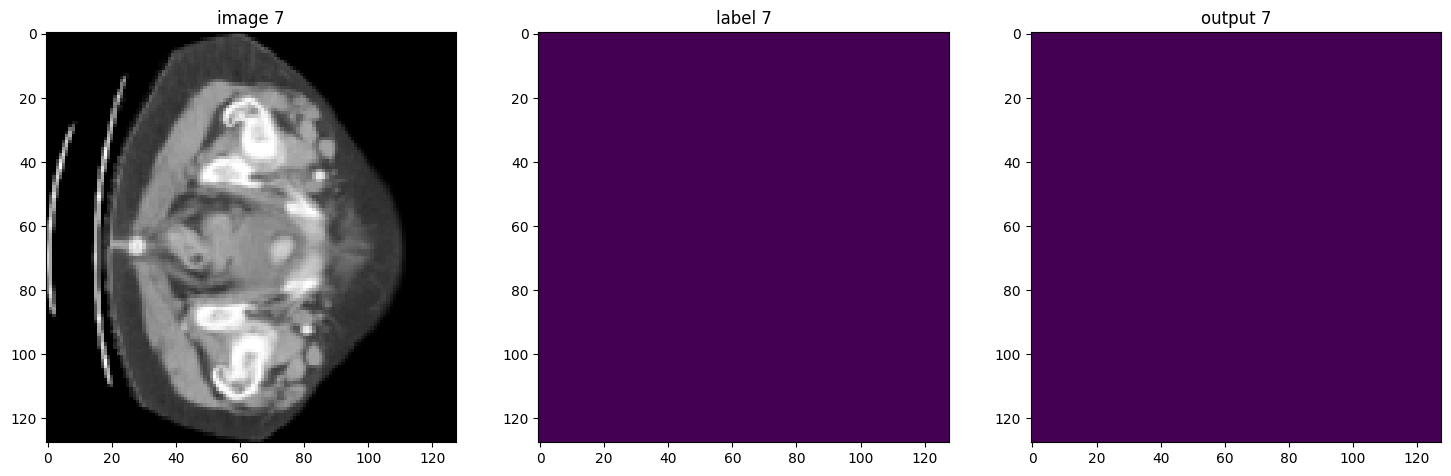

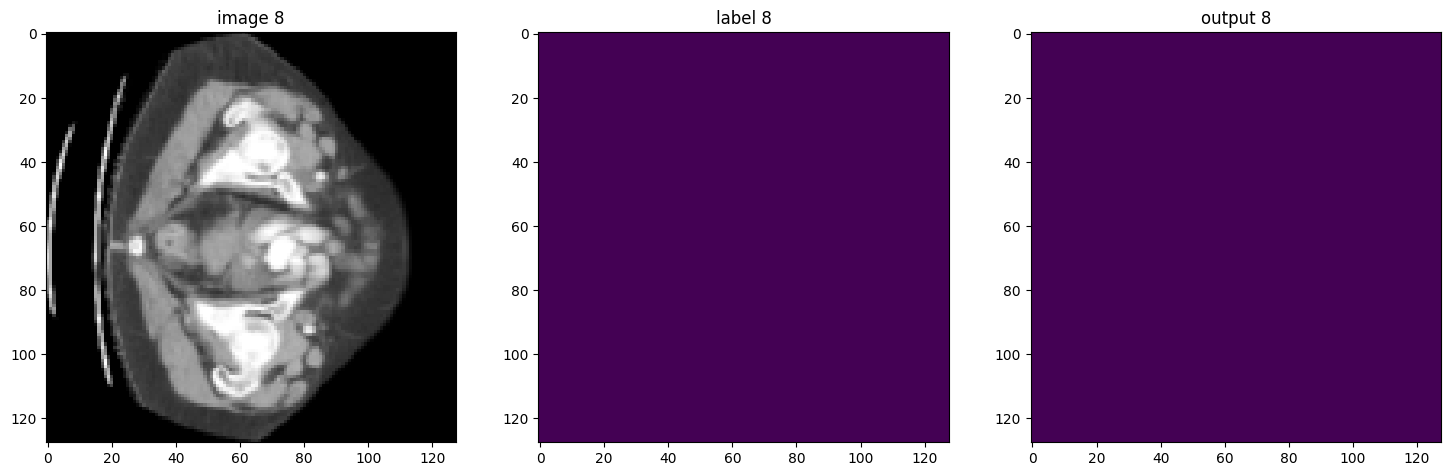

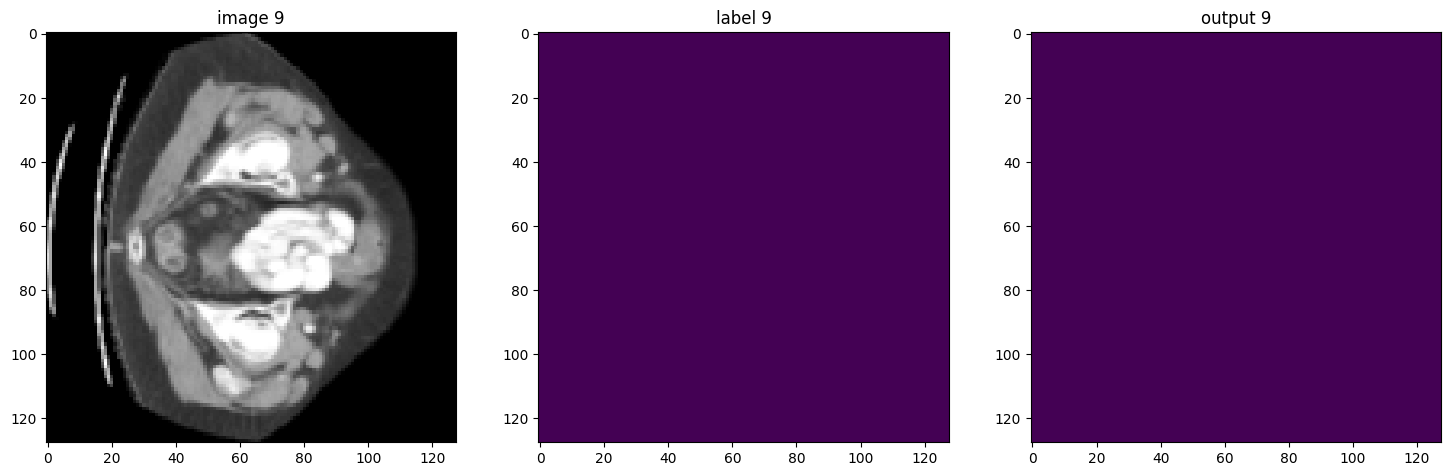

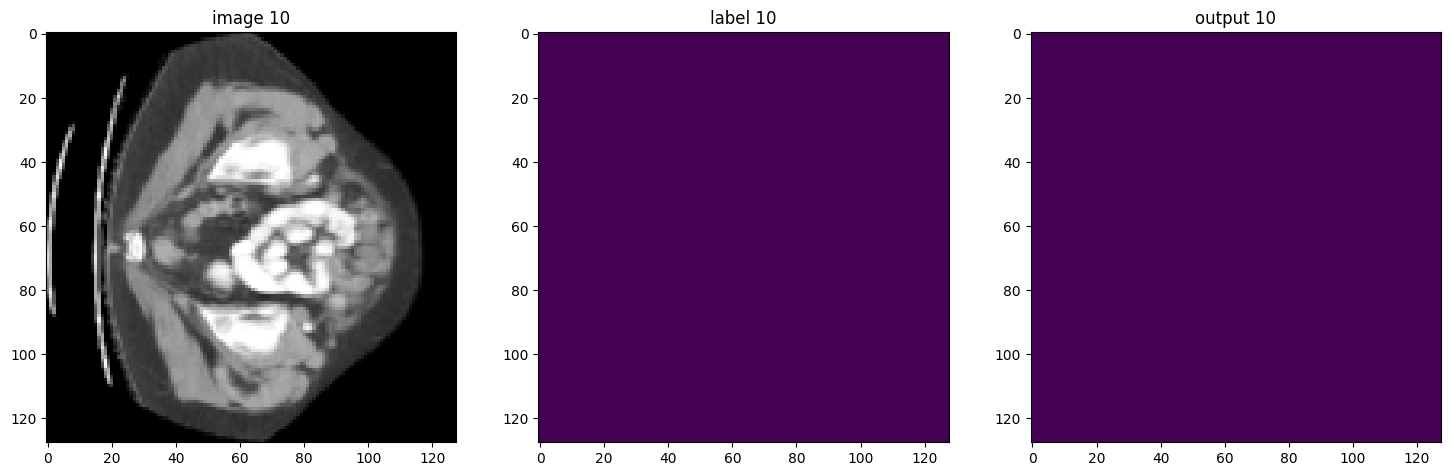

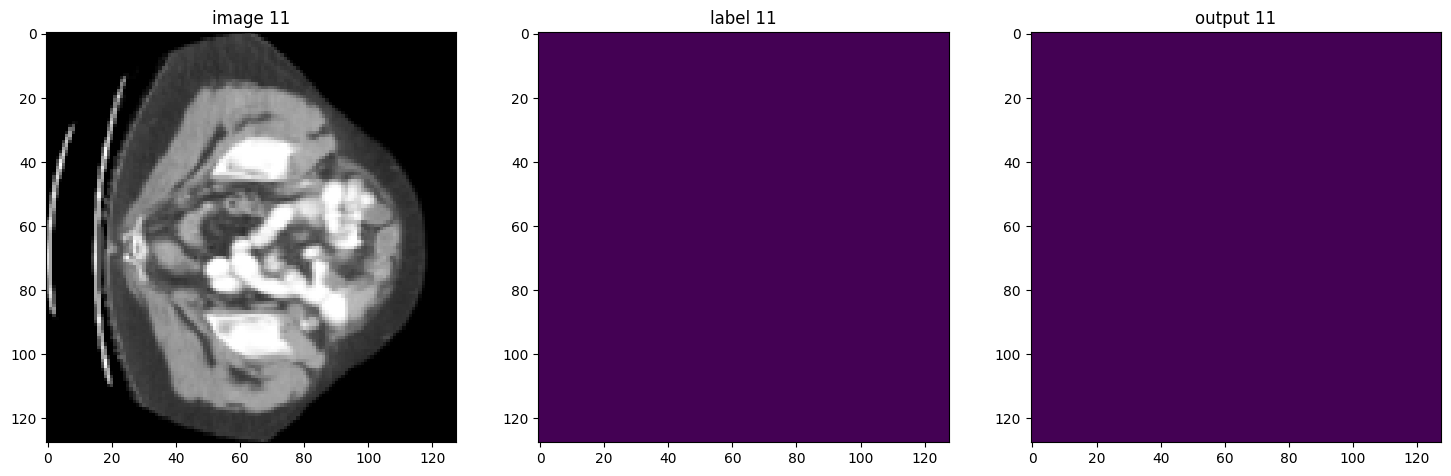

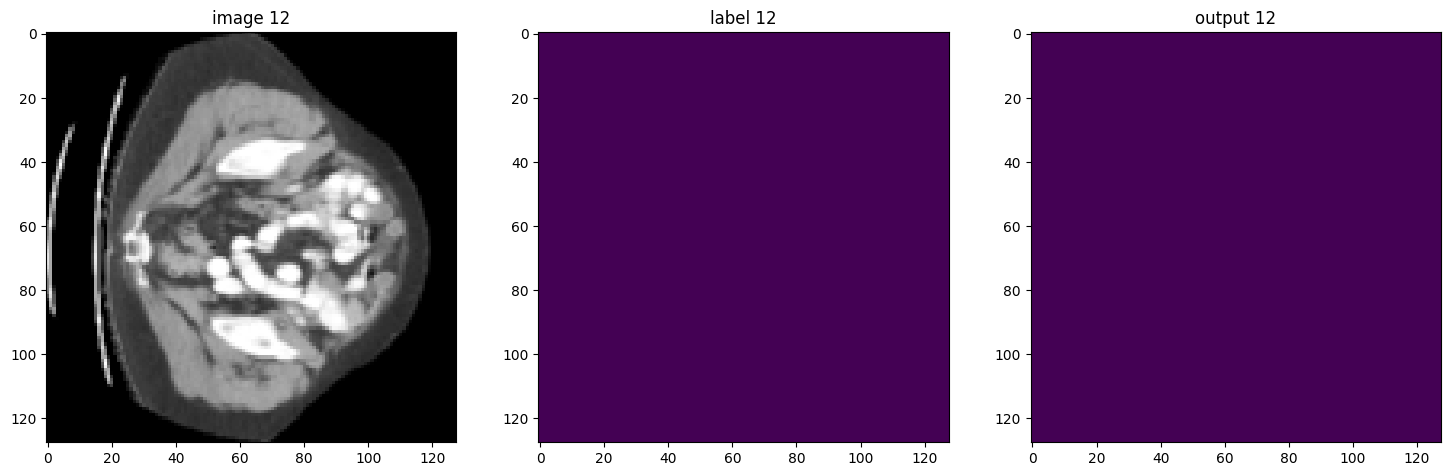

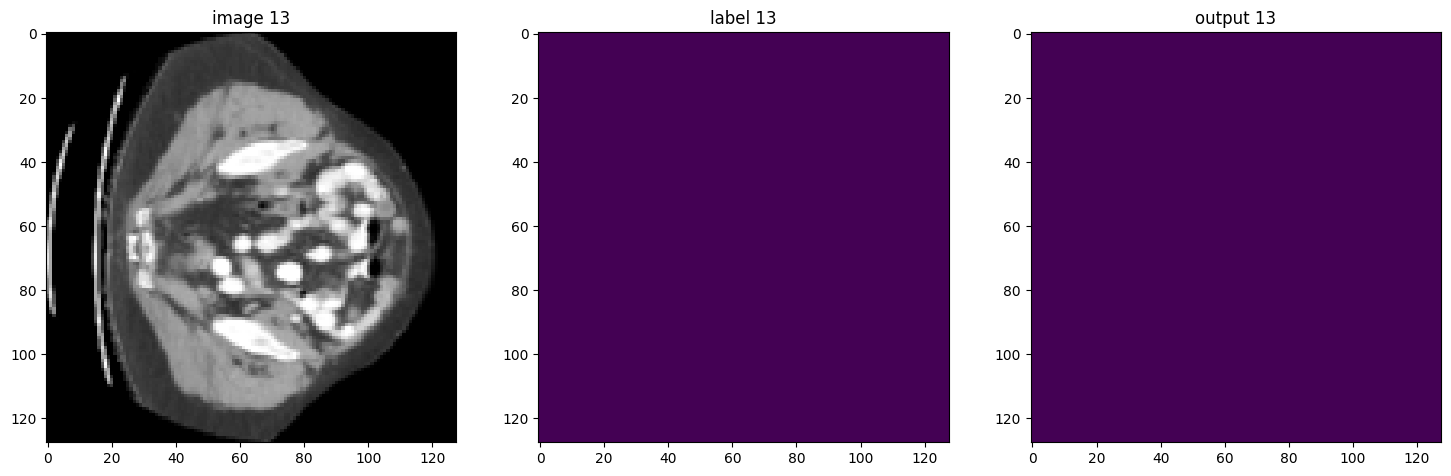

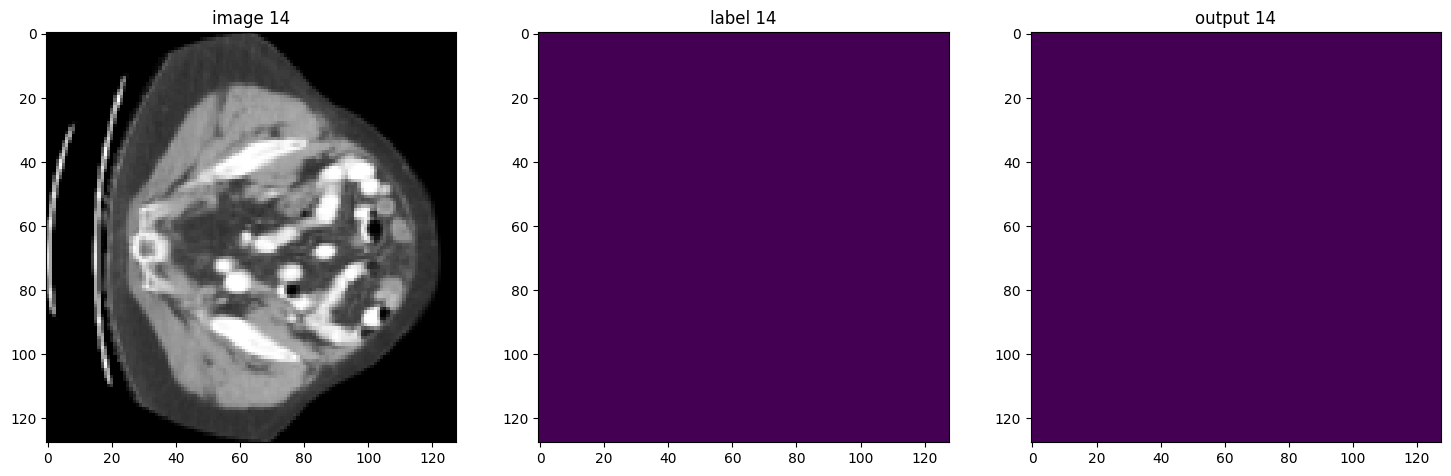

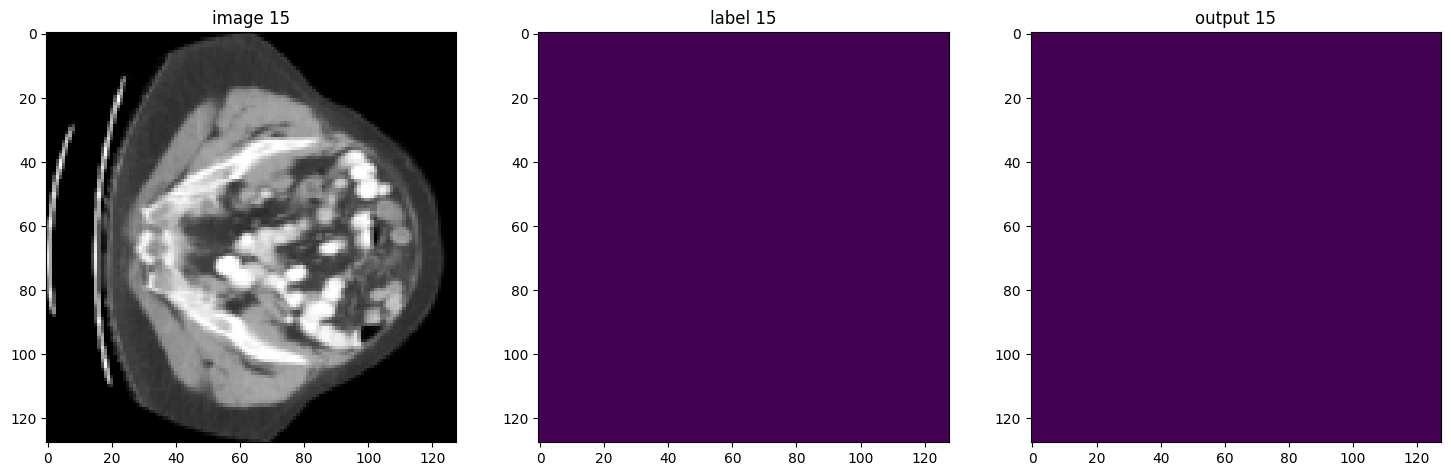

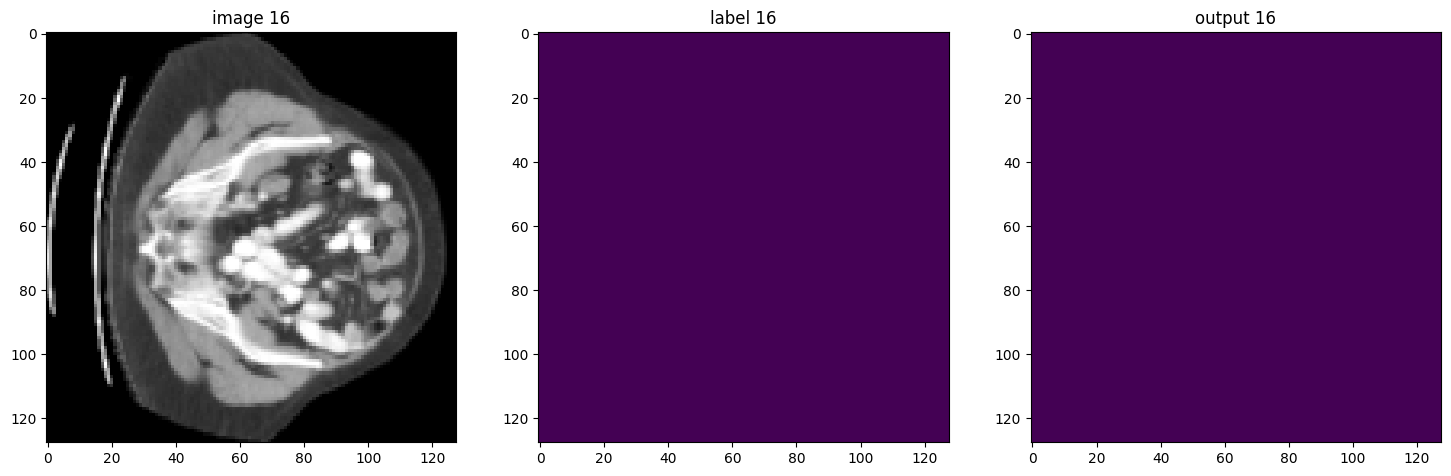

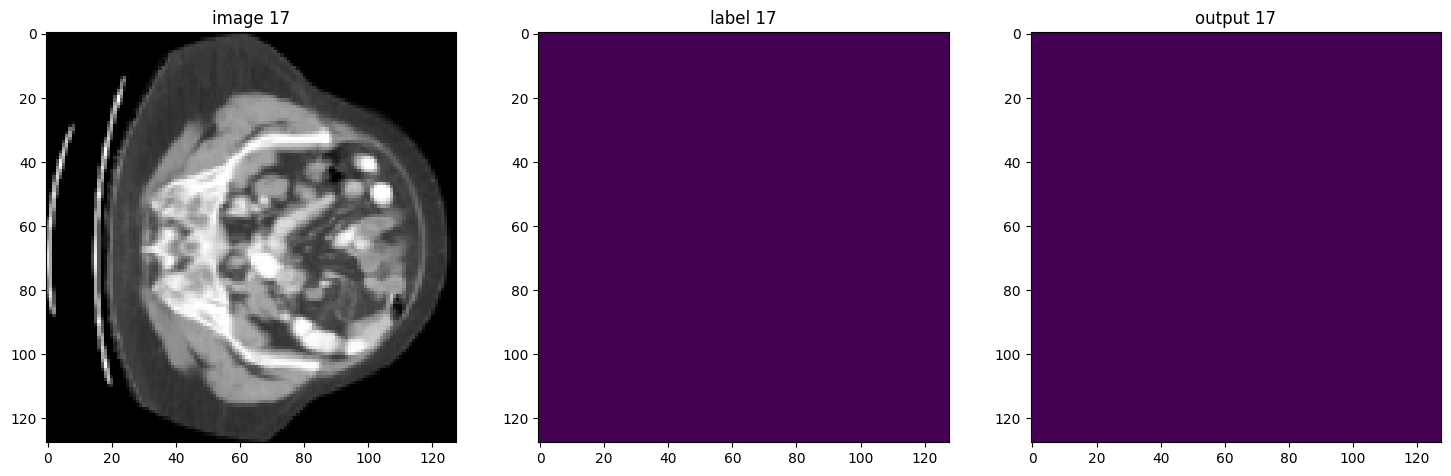

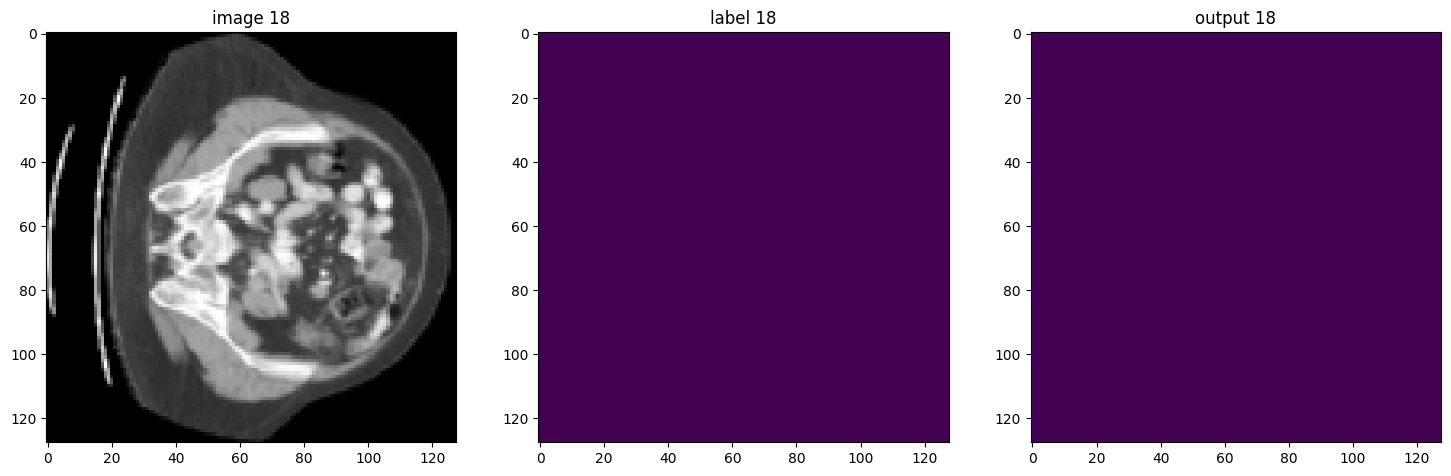

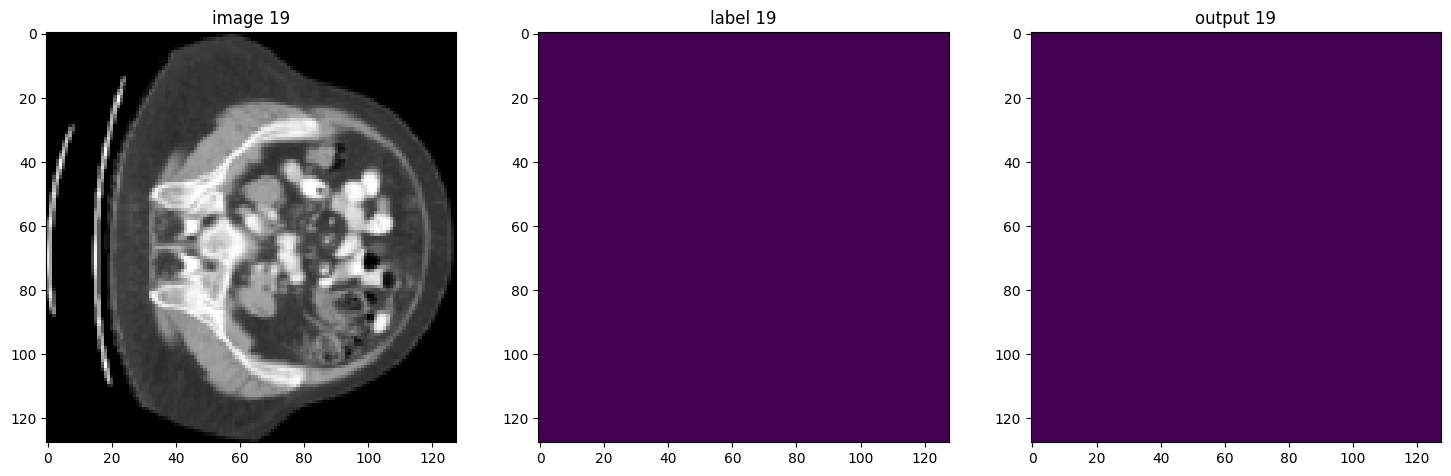

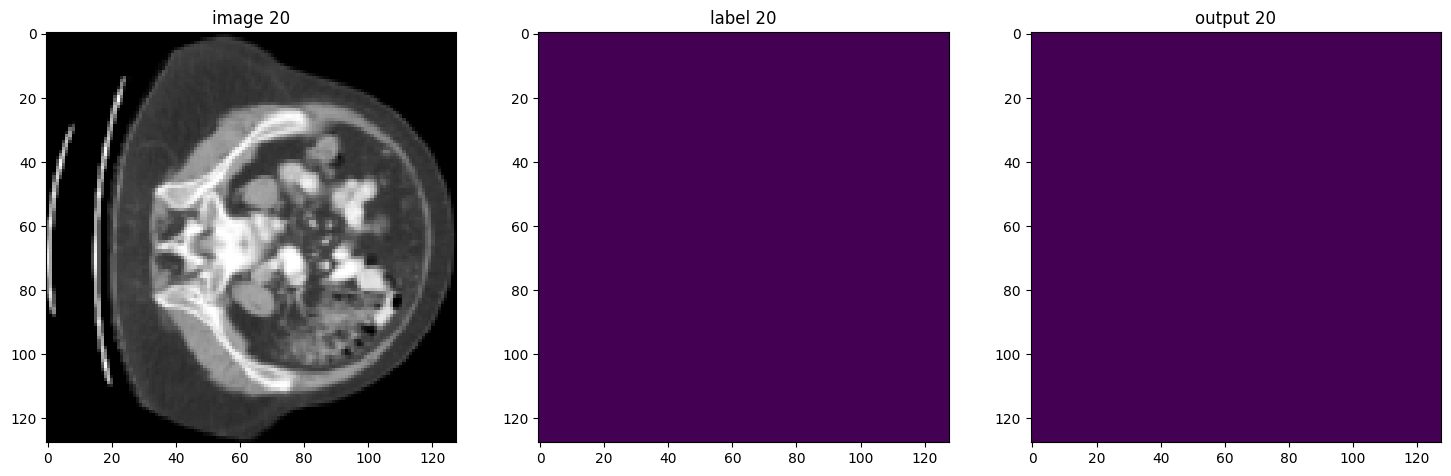

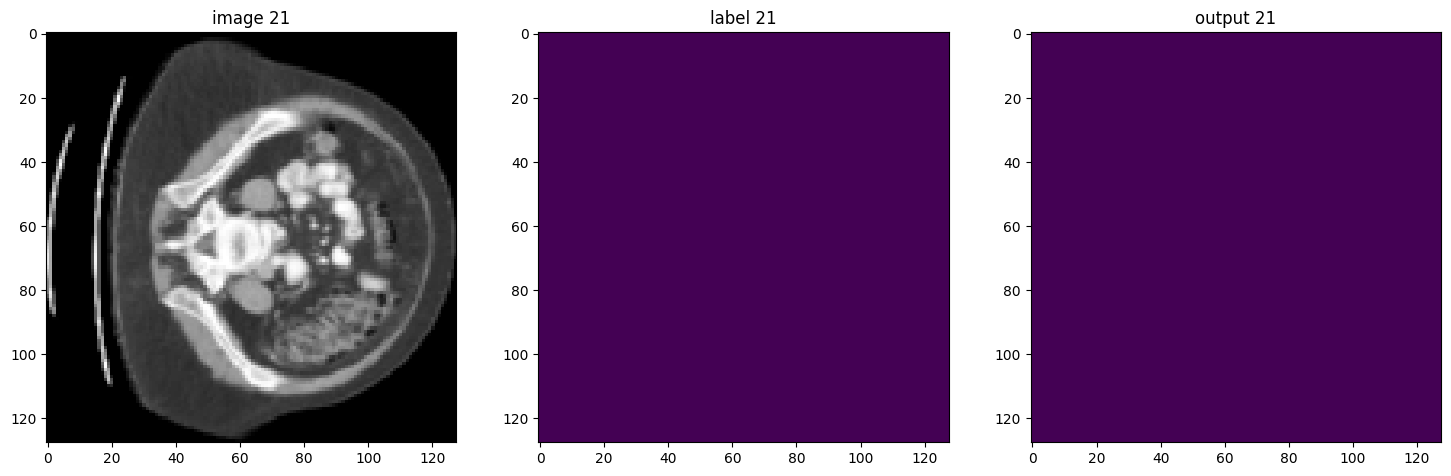

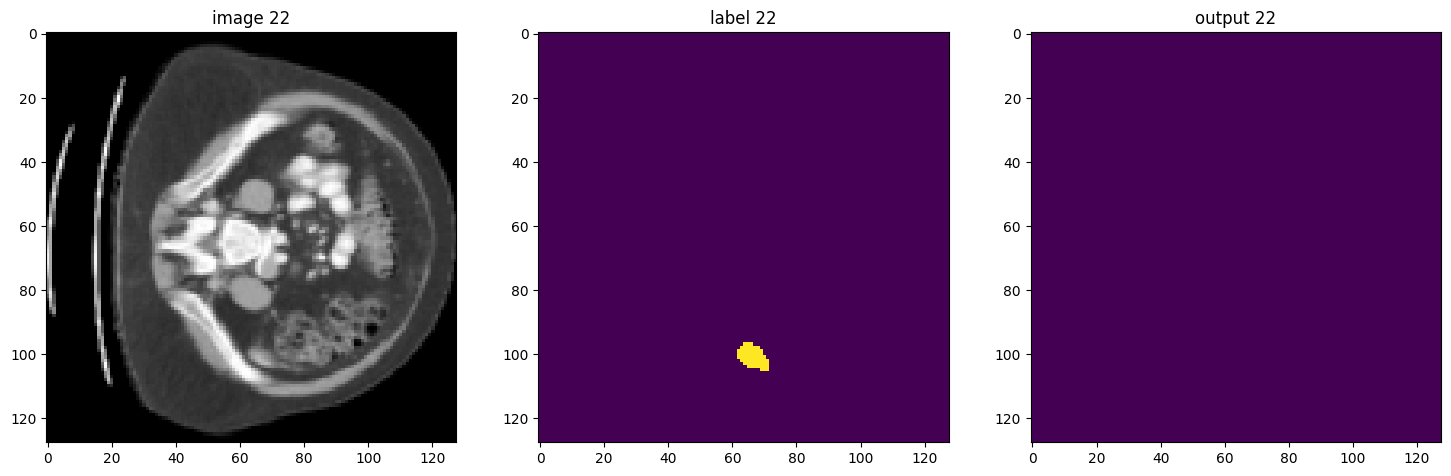

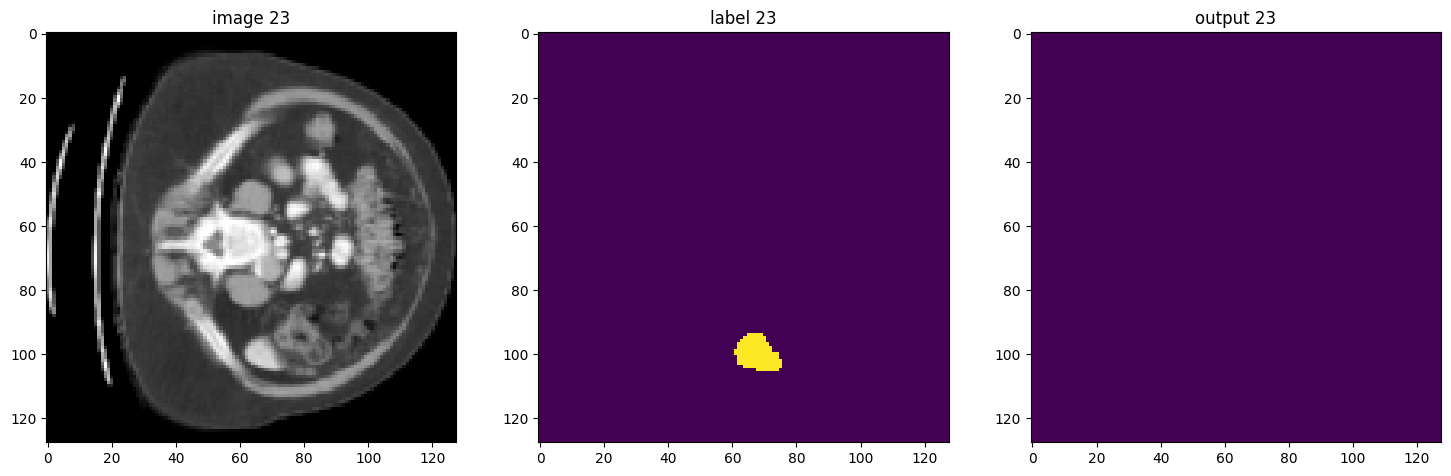

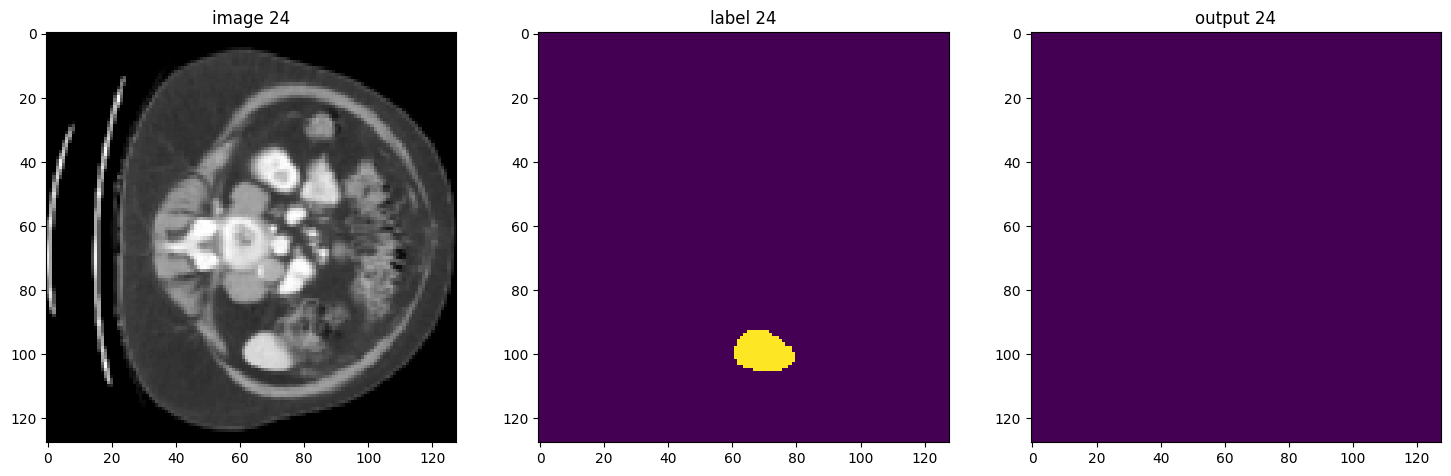

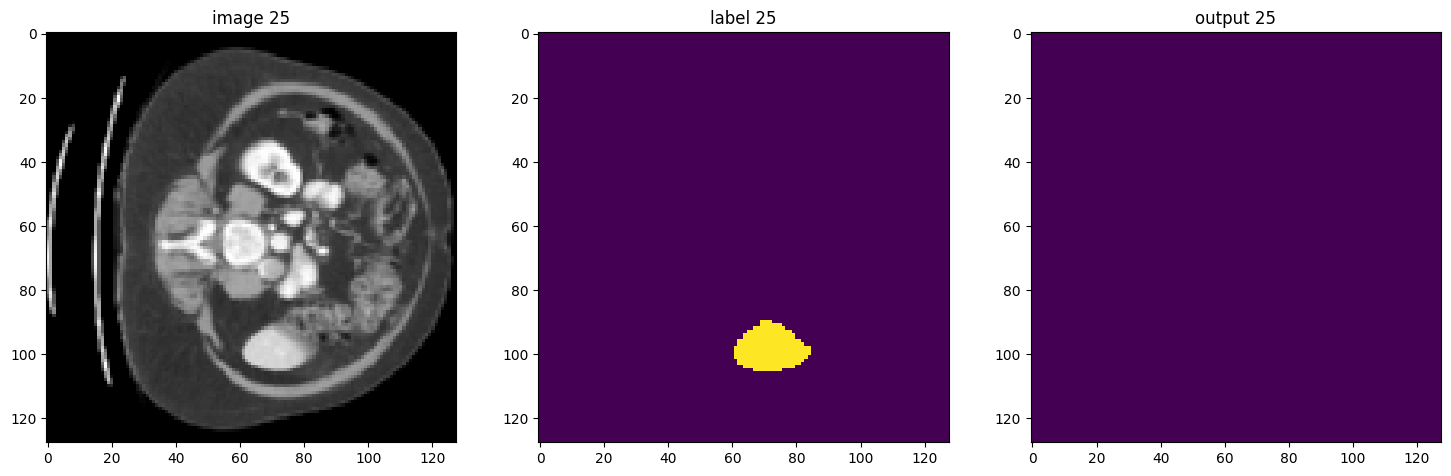

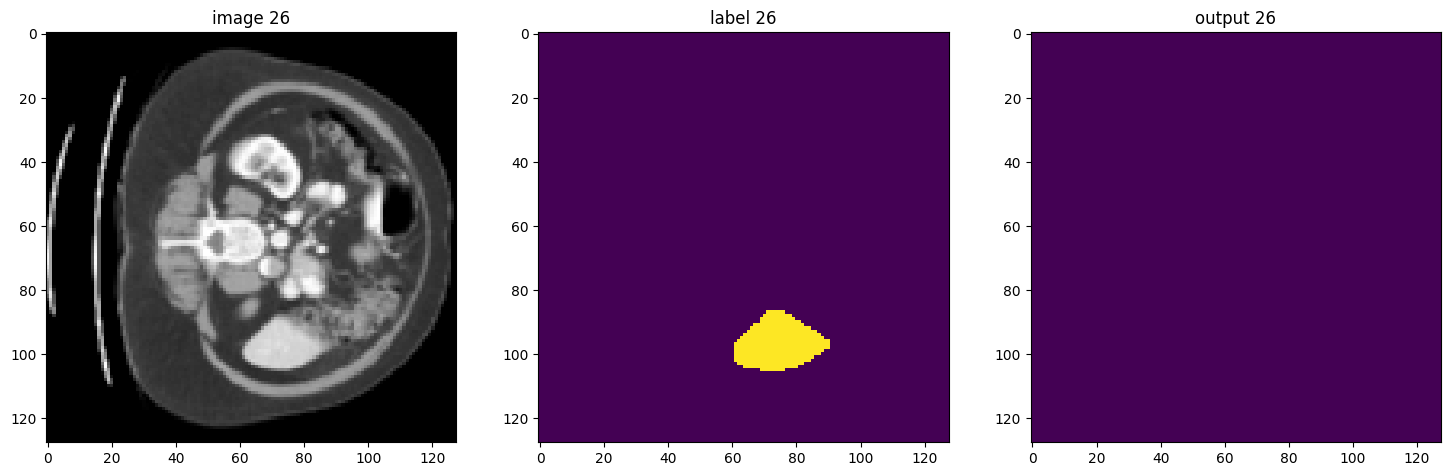

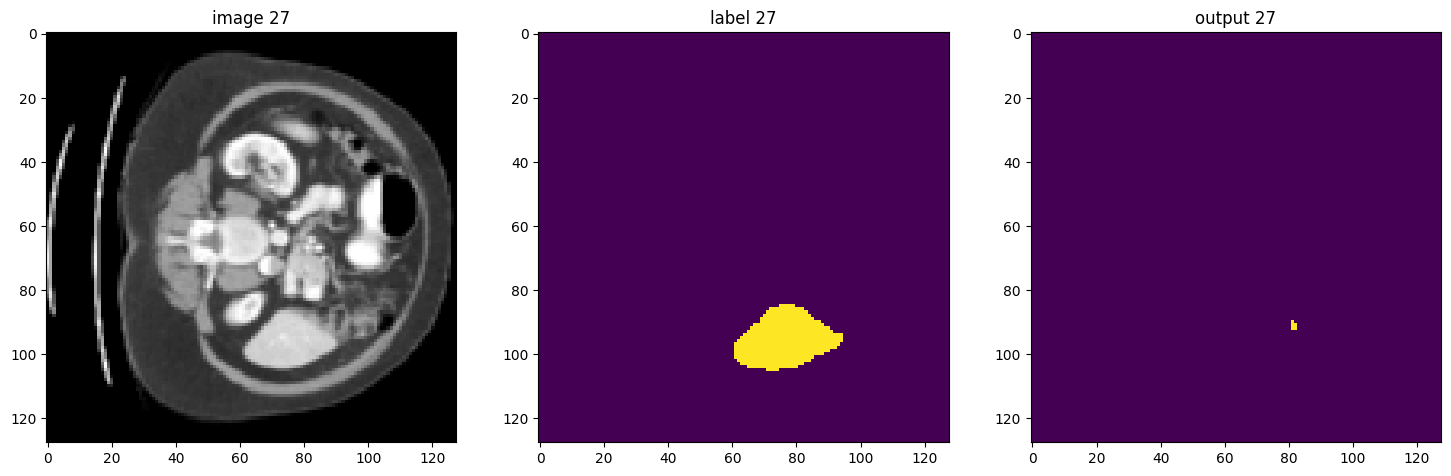

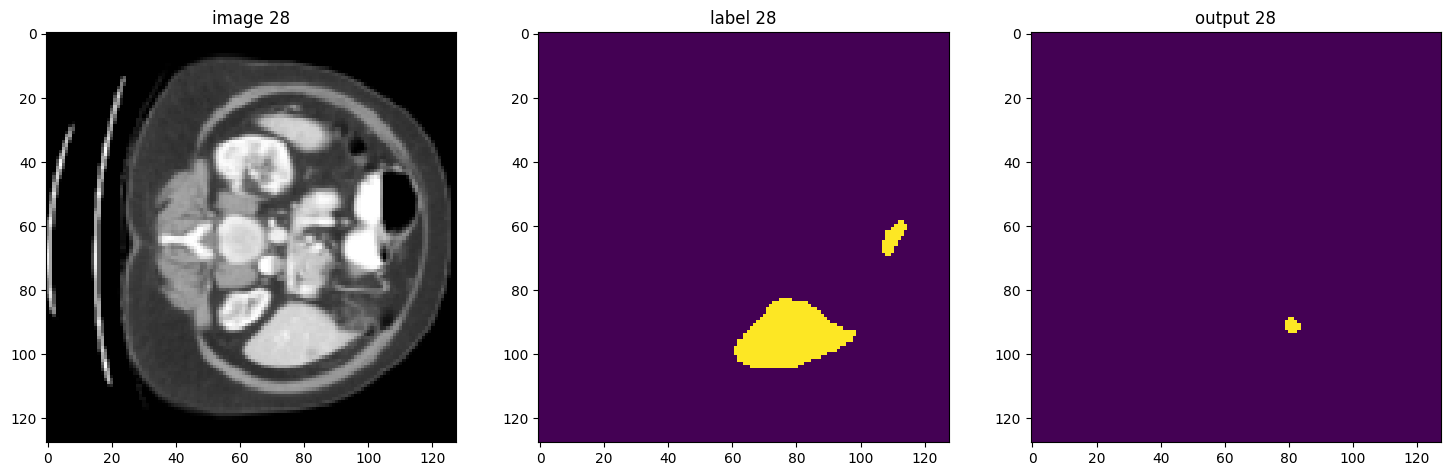

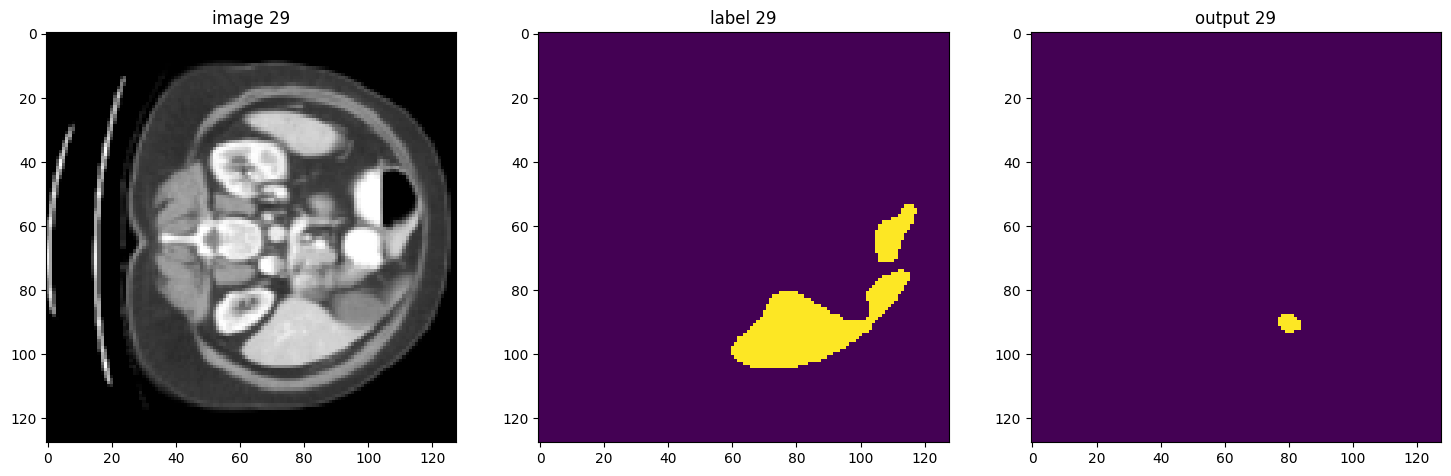

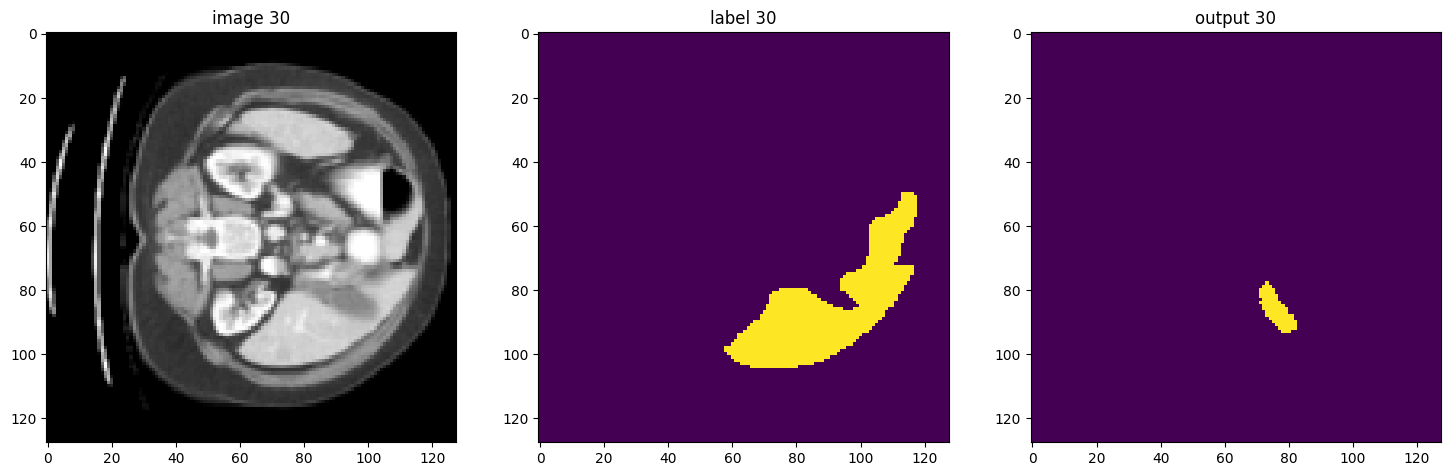

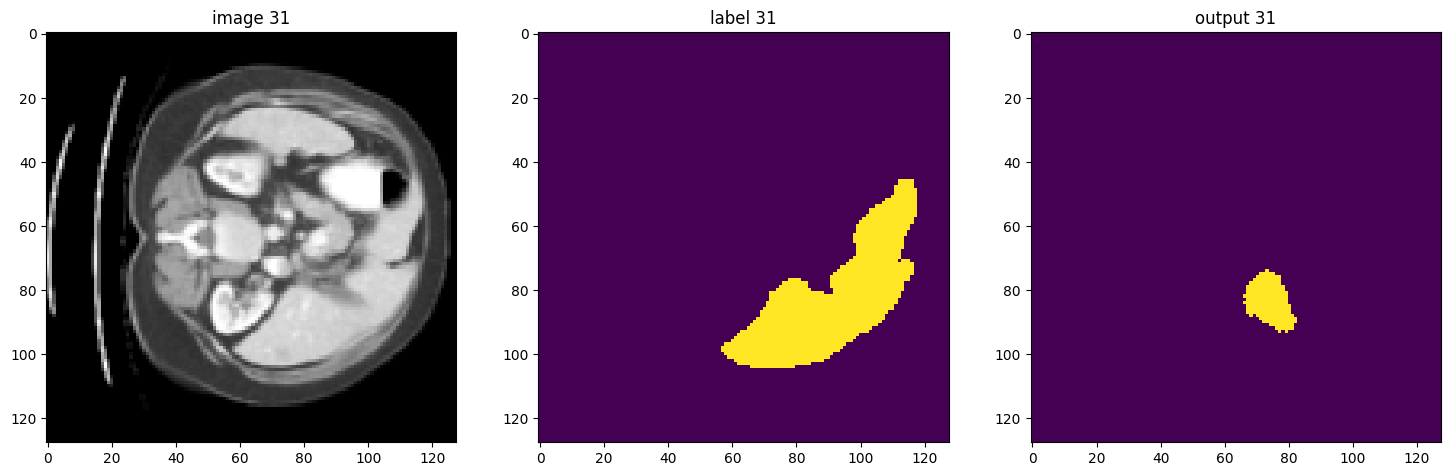

In [37]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference
from monai.transforms import Activations

In [39]:
def compute_metrics(pred, label):
    # Flatten the predicted and label arrays
    pred_flat = flatten_tensor(pred)
    label_flat = flatten_tensor(label)
    
    # Confusion Matrix (for binary segmentation)
    cm = confusion_matrix(label_flat, pred_flat)
    
    # Accuracy: correctly classified pixels / total pixels
    accuracy = accuracy_score(label_flat, pred_flat)
    
    # Precision: tp / (tp + fp)
    precision = precision_score(label_flat, pred_flat)
    
    # Dice Metric (2 * intersection / (sum of predicted and true positives))
    intersection = np.sum(pred_flat * label_flat)
    dice = (2. * intersection) / (np.sum(pred_flat) + np.sum(label_flat))
    
    # Dice Loss: 1 - Dice Metric
    dice_loss = 1 - dice
    
    return cm, accuracy, precision, dice, dice_loss

In [43]:
confusion_matrix_all = np.zeros((2, 2))  # For binary classification (background vs liver)

# Loop through the test set
for i, test_patient in enumerate(test_loader):
    # Get the test volume and ground truth segmentation
    t_volume = test_patient['vol'].to(device)
    t_segmentation = test_patient['seg'].to(device)
    
    # Get predictions using sliding window inference
    with torch.no_grad():
        test_outputs = sliding_window_inference(t_volume, roi_size, sw_batch_size, model)
        sigmoid_activation = Activations(sigmoid=True)
        test_outputs = sigmoid_activation(test_outputs)
        test_outputs = test_outputs > 0.5  # Threshold predictions
    
    # Loop over each slice of the volume for the current patient
    num_slices = test_outputs.shape[4]
    for slice_idx in range(num_slices):
        # Get the predicted and ground truth for the slice
        pred_slice = test_outputs[0, 1, :, :, slice_idx]  # Assuming output is binary, index 1 is for liver segmentation
        label_slice = t_segmentation[0, 0, :, :, slice_idx] != 0  # Binary mask: 1 for liver, 0 for background
        
        # Flatten arrays
        pred_flat = pred_slice.cpu().numpy().flatten()
        label_flat = label_slice.cpu().numpy().flatten()
        
        # Confusion Matrix
        cm = confusion_matrix(label_flat, pred_flat, labels=[0, 1])
        confusion_matrix_all += cm

# Extract confusion matrix values
TN, FP = confusion_matrix_all[0, 0], confusion_matrix_all[0, 1]
FN, TP = confusion_matrix_all[1, 0], confusion_matrix_all[1, 1]

# Compute metrics using confusion matrix values
total_pixels = TN + FP + FN + TP
accuracy = (TP + TN) / total_pixels if total_pixels > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
dice_loss = 1 - dice

# Print results
print("Confusion Matrix (Overall):\n", confusion_matrix_all)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Dice Metric: {dice:.4f}")
print(f"Dice Loss: {dice_loss:.4f}")


Confusion Matrix (Overall):
 [[10183590.    24984.]
 [  221079.    56107.]]
Accuracy: 0.9765
Precision: 0.6919
Recall: 0.2024
Dice Metric: 0.3132
Dice Loss: 0.6868


In [44]:
total_pixels = np.sum(confusion_matrix_all)
confusion_matrix_prob = confusion_matrix_all / total_pixels

# Extract confusion matrix values
TN, FP = confusion_matrix_prob[0, 0], confusion_matrix_prob[0, 1]
FN, TP = confusion_matrix_prob[1, 0], confusion_matrix_prob[1, 1]

# Print normalized confusion matrix
print("Confusion Matrix (Probability Form):\n", confusion_matrix_prob

Confusion Matrix (Probability Form):
 [[0.97118282 0.00238266]
 [0.02108374 0.00535078]]


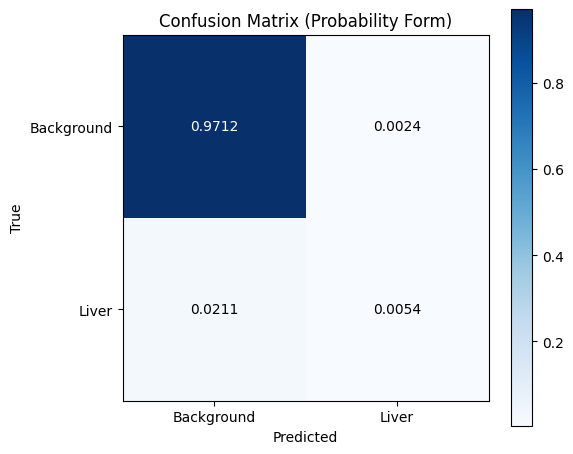

Probability of True Negative (TN): 0.9712
Probability of False Positive (FP): 0.0024
Probability of False Negative (FN): 0.0211
Probability of True Positive (TP): 0.0054


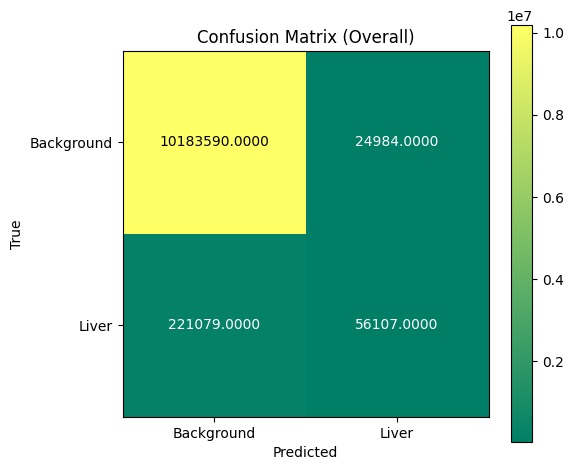

Number of True Negative (TN): 10183590.0000
Number of False Positive (FP): 24984.0000
Number of False Negative (FN): 221079.0000
Number of True Positive (TP): 56107.0000


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming confusion_matrix_all is the confusion matrix in absolute form
# confusion_matrix_all is in the form: [[TN, FP], [FN, TP]]

# Normalize the confusion matrix to get probabilities
total_pixels = np.sum(confusion_matrix_all)
confusion_matrix_prob = confusion_matrix_all / total_pixels

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(confusion_matrix_prob, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Probability Form)")
plt.colorbar()

# Add labels and annotations
classes = ['Background', 'Liver']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Annotate the matrix with the probabilities
thresh = confusion_matrix_prob.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{confusion_matrix_prob[i, j]:.4f}',
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if confusion_matrix_prob[i, j] > thresh else "black")

# Labels for axes
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(f"Probability of True Negative (TN): {confusion_matrix_prob[0, 0]:.4f}")
print(f"Probability of False Positive (FP): {confusion_matrix_prob[0, 1]:.4f}")
print(f"Probability of False Negative (FN): {confusion_matrix_prob[1, 0]:.4f}")
print(f"Probability of True Positive (TP): {confusion_matrix_prob[1, 1]:.4f}")

plt.figure(figsize=(6, 5))
plt.imshow(confusion_matrix_all, interpolation='nearest', cmap='summer')
plt.title("Confusion Matrix (Overall)")
plt.colorbar()

# Add labels and annotations
classes = ['Background', 'Liver']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


thresh = confusion_matrix_all.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{confusion_matrix_all[i, j]:.4f}',
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="black" if confusion_matrix_all[i, j] > thresh else "white")

# Labels for axes
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(f"Number of True Negative (TN): {confusion_matrix_all[0, 0]:.4f}")
print(f"Number of False Positive (FP): {confusion_matrix_all[0, 1]:.4f}")
print(f"Number of False Negative (FN): {confusion_matrix_all[1, 0]:.4f}")
print(f"Number of True Positive (TP): {confusion_matrix_all[1, 1]:.4f}")